# Load Data

In [1]:
#!/usr/bin/env python
# coding: utf-8
import os
import json
from tqdm import tqdm

import numpy as np
import pandas as pd

import multiprocessing as mp
import matplotlib.pyplot as plt

In [2]:
# Hyperparams
mirror = False
MAX_FRAMES = 15
MAX_SEQ_LENGTH = MAX_FRAMES
N_PTS = 543
N_DIMS = 2
NUM_FEATURES = N_PTS*N_DIMS
RESIZE_METHOD = 'nearest'

PARTS_USED = ('lhand', 'rhand', 'lips')

PATIENCE = 8
BATCH_SIZE = 256
EPOCHS = 500

LR_START = 5e-5
REDUCE_LR_PATIENCE = 4
REDUCE_LR_FACTOR = 0.2
REDUCE_LR_COOLDOWN = 2 # Default: 0


# Defined
MAIN_PARTS = ('lhand', 'rhand', 'face', 'pose')
START_FACE, END_FACE = (0, 468)
START_LHAND, END_LHAND = (468, 489)
START_POSE, END_POSE = (489, 522)
START_RHAND, END_RHAND = (522, 543)

LHAND_PTS = [i for i in range(START_LHAND, END_LHAND)]
RHAND_PTS = [i for i in range(START_RHAND, END_RHAND)]
FACE_PTS = [i for i in range(START_FACE, END_FACE)]
POSE_PTS = [i for i in range(START_POSE, END_POSE)]
LIPS_PTS = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
PART_PTS = dict(
    lhand=LHAND_PTS,
    rhand=RHAND_PTS,
    face=FACE_PTS,
    pose=POSE_PTS,
    lips=LIPS_PTS,
)


In [3]:
# Naming
X_npy_base = f'{MAX_FRAMES:02}_frames_key_resize_{RESIZE_METHOD}_by_part.npy'
y_npy_fname = f'y.npy'

COMP = os.environ.get('COMP_NAME', '?')
# MODEL_DIR = '/'.join((__file__).split('/')[:-1])
# print(f'{MODEL_DIR=}')
METRIC_STR = '_xx_val_acc-'
MODEL_NAME = "MODEL"

if all(p in PARTS_USED for p in MAIN_PARTS):
    all_parts_str = 'all'
else:
    all_parts_str = '_'.join(f'{p}' for p in PARTS_USED)


model_details = (
    f'{MODEL_NAME}'
    f'-key_frames_{all_parts_str}_resize_{RESIZE_METHOD}'
    f'-{MAX_FRAMES:02}_frames'
    f'-{N_PTS}_pts_per_frame'
    f'-{N_DIMS}_dims'
    f'-{BATCH_SIZE}_batch_size'
    f'{"-mirror" if mirror else ""}'
)

DATA_ROOT = '../data/'
DF_TRAIN =  f'{DATA_ROOT}train.csv'
train = pd.read_csv(DF_TRAIN)

class CFG:
    data_path = DATA_ROOT
    quick_experiment = False
    is_training = True
    use_aggregation_dataset = True
    num_classes = 250
    rows_per_frame = 543 

def load_relevant_data_subset_with_imputation(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    data.replace(np.nan, 0, inplace=True)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / CFG.rows_per_frame)
    data = data.values.reshape(n_frames, CFG.rows_per_frame, len(data_columns))
    return data.astype(np.float32)

def read_dict(file_path):
    path = os.path.expanduser(file_path)
    with open(path, "r") as f:
        dic = json.load(f)
    return dic

train = pd.read_csv(f"{CFG.data_path}train.csv")
label_index = read_dict(f"{CFG.data_path}sign_to_prediction_index_map.json")
index_label = {label_index[key]: key for key in label_index}
train["label"] = train["sign"].map(lambda sign: label_index[sign])

X_parts = dict(
    lhand=None,
    rhand=None,
    face=None,
    pose=None,
    lips=None,
)


for part_name in X_parts.keys():
    X_parts[part_name] = np.load(
        f'../X-{part_name}-{X_npy_base}'
    )
y = np.load('../' + y_npy_fname)

## Subset: Right Hand

In [4]:
X_rhand = X_parts['rhand']
X_rhand.shape

(94477, 15, 42)

# Representative Images

In [5]:
from sklearn.cluster import KMeans
from visualize import viz_hand

In [6]:
print(label_index)

{'TV': 0, 'after': 1, 'airplane': 2, 'all': 3, 'alligator': 4, 'animal': 5, 'another': 6, 'any': 7, 'apple': 8, 'arm': 9, 'aunt': 10, 'awake': 11, 'backyard': 12, 'bad': 13, 'balloon': 14, 'bath': 15, 'because': 16, 'bed': 17, 'bedroom': 18, 'bee': 19, 'before': 20, 'beside': 21, 'better': 22, 'bird': 23, 'black': 24, 'blow': 25, 'blue': 26, 'boat': 27, 'book': 28, 'boy': 29, 'brother': 30, 'brown': 31, 'bug': 32, 'bye': 33, 'callonphone': 34, 'can': 35, 'car': 36, 'carrot': 37, 'cat': 38, 'cereal': 39, 'chair': 40, 'cheek': 41, 'child': 42, 'chin': 43, 'chocolate': 44, 'clean': 45, 'close': 46, 'closet': 47, 'cloud': 48, 'clown': 49, 'cow': 50, 'cowboy': 51, 'cry': 52, 'cut': 53, 'cute': 54, 'dad': 55, 'dance': 56, 'dirty': 57, 'dog': 58, 'doll': 59, 'donkey': 60, 'down': 61, 'drawer': 62, 'drink': 63, 'drop': 64, 'dry': 65, 'dryer': 66, 'duck': 67, 'ear': 68, 'elephant': 69, 'empty': 70, 'every': 71, 'eye': 72, 'face': 73, 'fall': 74, 'farm': 75, 'fast': 76, 'feet': 77, 'find': 78, '

In [7]:
n_repeats = 50
classes = [
    0,
]
n_classes = len(classes)
k = n_repeats * n_classes

# mask = (y<=50)
mask = np.isin(y, classes)

N = mask.sum() # instances
print(f'{N=}')
new_label = np.zeros((N*15))
for i,label in enumerate(y[mask][:N]):
    new_label[i*15:(i+1)*15] = label
print(f'{np.unique(new_label)=}')

N=385
np.unique(new_label)=array([0.])


In [8]:
X_sample = X_rhand[mask][:N].reshape(N*15,42)
X_sample.shape

(5775, 42)

In [9]:
representative_frames_fname = 'representative_frames.npy'
X_kmeans_dist_fname = 'X_kmeans_dist.npy'

try:
    representative_frames = np.load(
        representative_frames_fname,
        
    )
    X_kmeans_dist = np.load(
        X_kmeans_dist_fname,
   )
except:
    kmeans = KMeans(
        n_clusters=k,
        random_state=27,
        n_init='auto',
    )
    #
    X_kmeans_dist = kmeans.fit_transform(X_sample)
    display(X_kmeans_dist.shape)


    np.save(
        representative_frames_fname,
        representative_frames,
    )
    np.save(
        X_kmeans_dist_fname,
        X_kmeans_dist,
    )

representative_frame_idx = np.argmin(X_kmeans_dist, axis=0)
representative_frames = X_sample[representative_frame_idx]
representative_frame_labels = tuple(index_label[l] for l in new_label[representative_frame_idx])
display(representative_frames.shape)

(50, 42)

In [10]:
kmeans = KMeans(
    n_clusters=k,
    random_state=27,
    n_init='auto',
)
#
kmeans.fit(X_sample)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

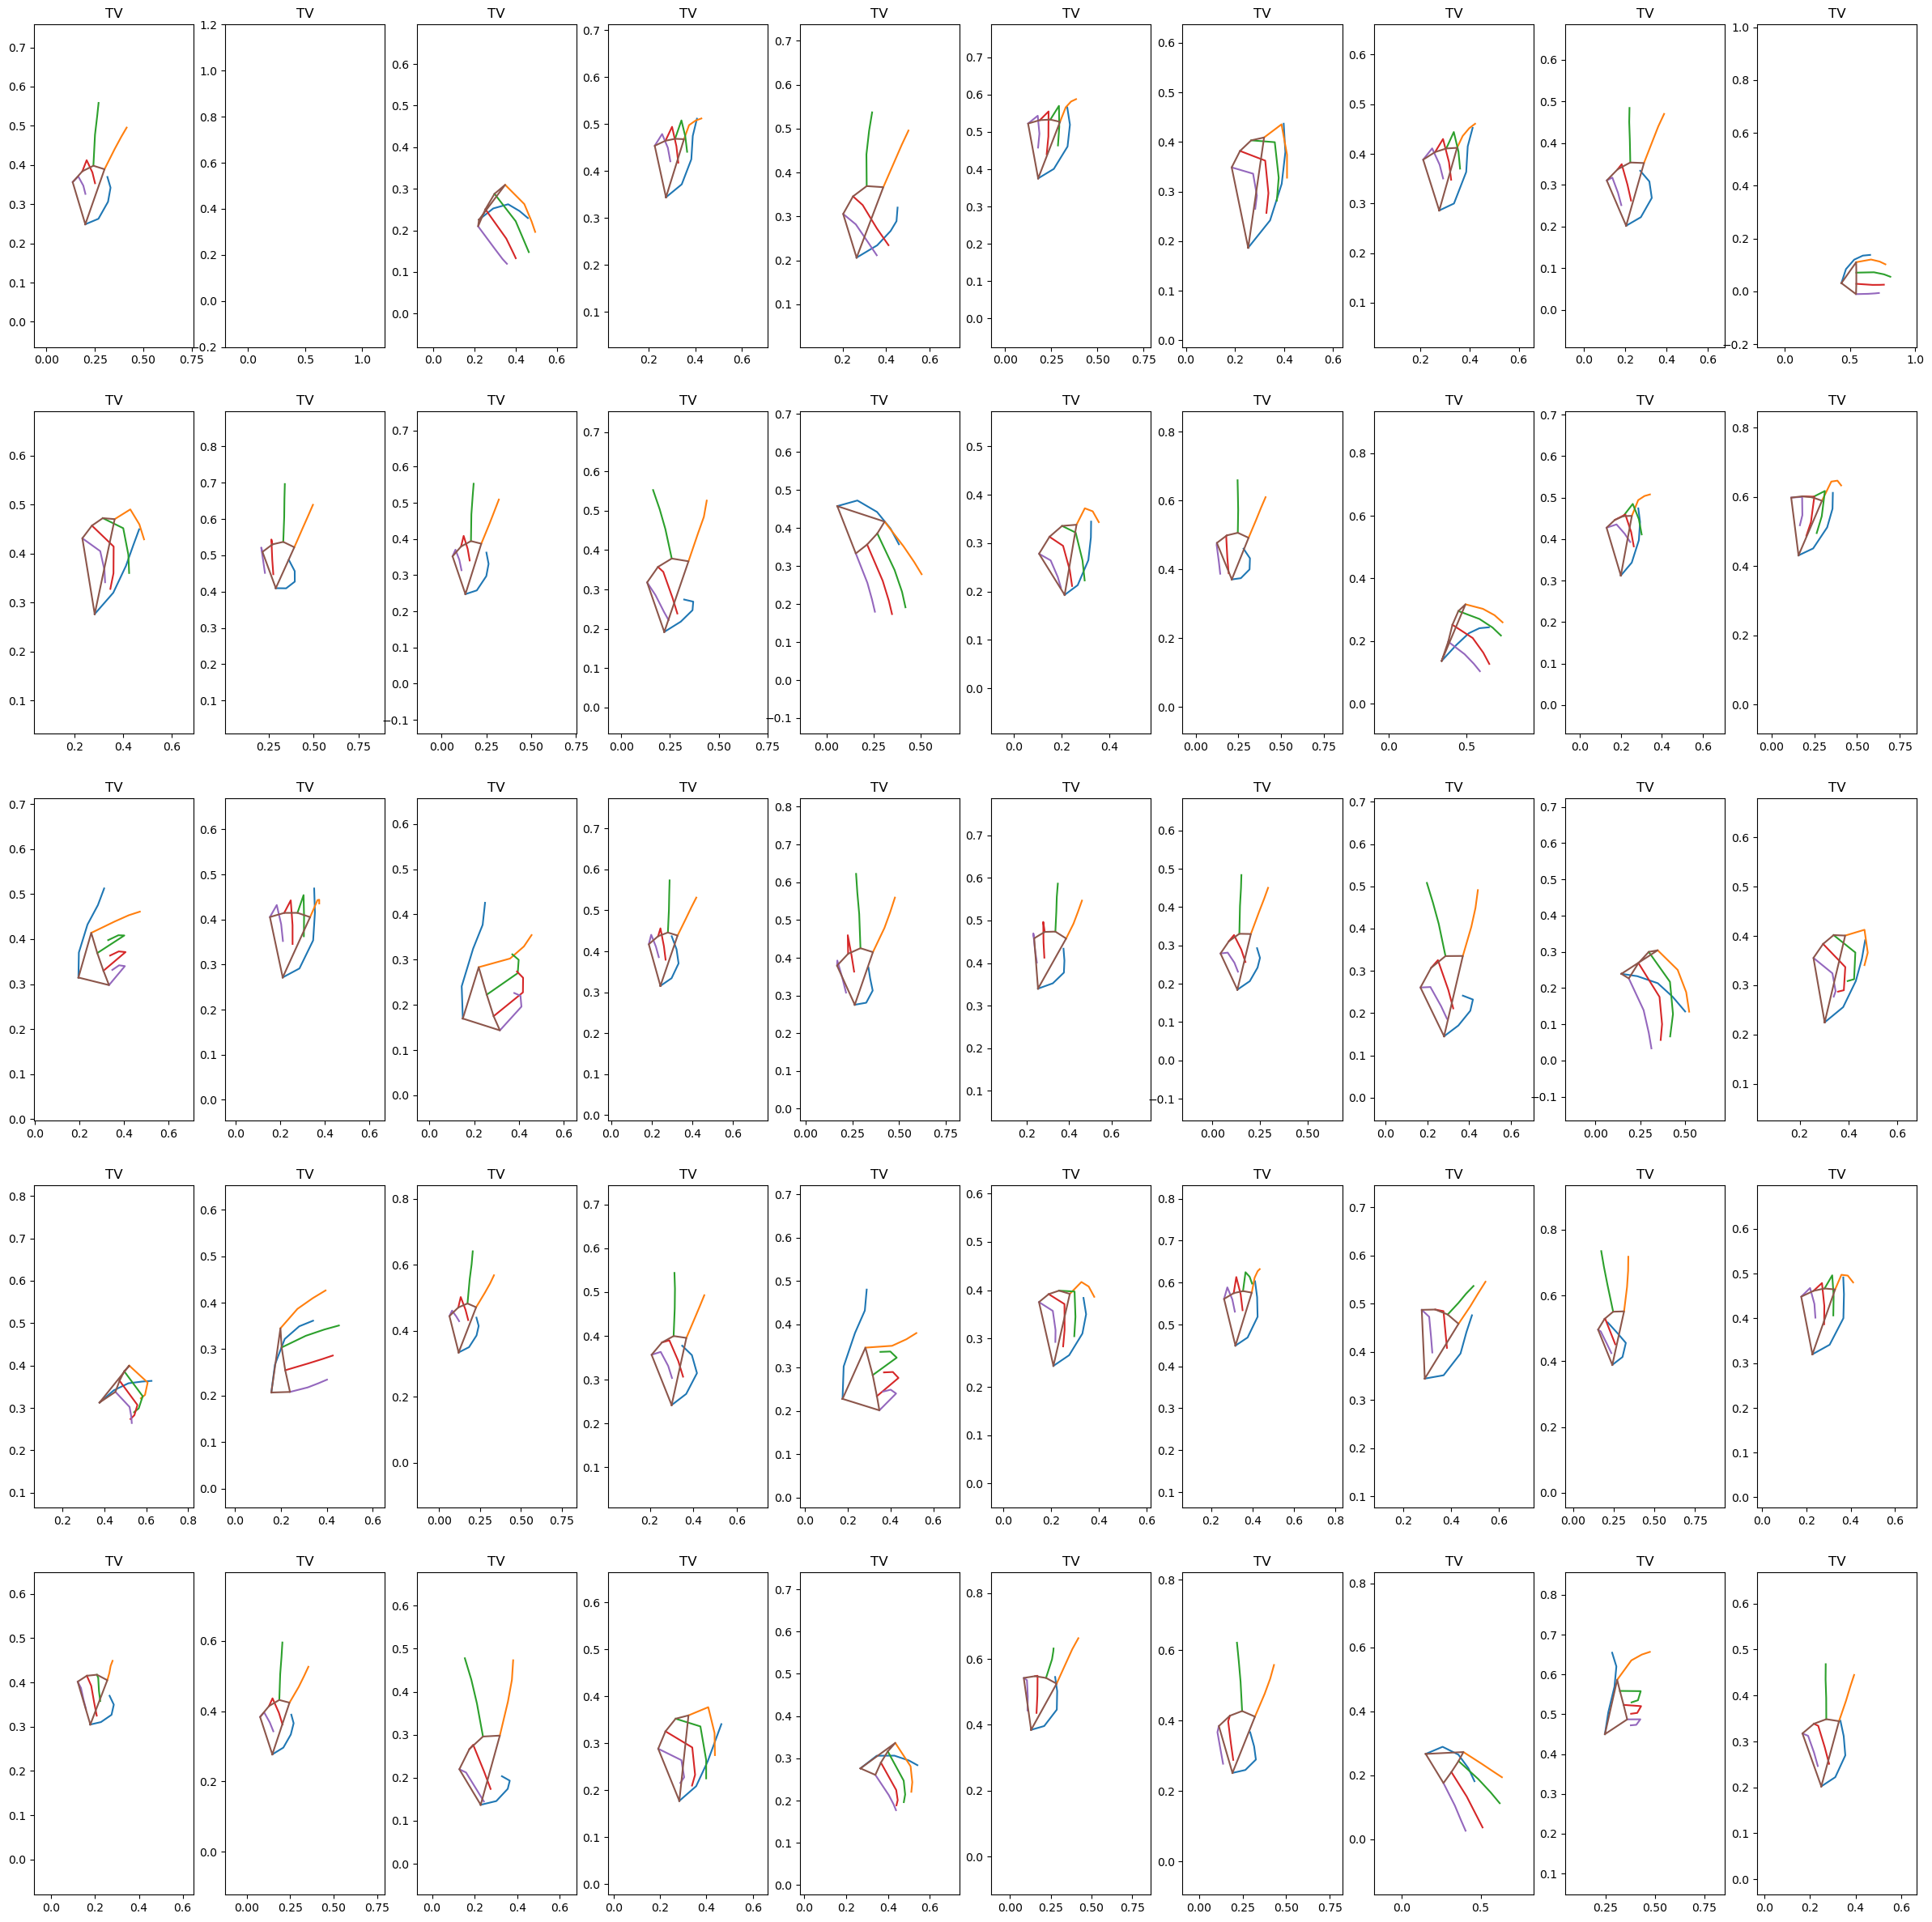

In [11]:
fig = plt.figure(figsize=(5*6, 10*3))

for j in range(k):
    ax = fig.add_subplot(5, 10, j+1)
    f_rhand = representative_frames[j].reshape(-1,2).copy()
    viz_hand(
        ax=ax,
        hand_frame=f_rhand,
        label=representative_frame_labels[j],
    )

In [12]:
# fig = plt.figure(figsize=(n_classes*3, n_repeats*4))
# fig.add_subplot()
# # for j in range(k):
# for j in range(min(5,k)):
#     ax = fig.add_subplot(n_repeats, n_classes, j+1)
#     f_rhand = representative_frames[j].reshape(-1,2).copy()
#     viz_hand(
#         ax=ax,
#         hand_frame=f_rhand,
#         label=representative_frame_labels[j],
#     )

## Label

In [13]:
handshapes = {
    0:'null',
    1:'v_out',
    2:'c_closed',
    3:'a',
    4:'t',
    5:'b_claw',
    6:'b',
    7:'t_closed',
    8:'point',
    # a_closed=9,
}

### Sign: "TV"

In [14]:
y_representatives = np.array(
    [
        1, 0, 2, 3, 1, 4, 4, 4, 1, 5,
        4, 1, 1, 1, 6, 7, 1, 2, 4, 7,
        8, 4, 8, 1, 1, 1, 1, 1, 2, 3,
        3, 6, 1, 1, 8, 7, 4, 1, 1, 4,
        8, 1, 1, 3, 2, 1, 1, 6, 8, 1,
    ],
    dtype=np.int32,
)

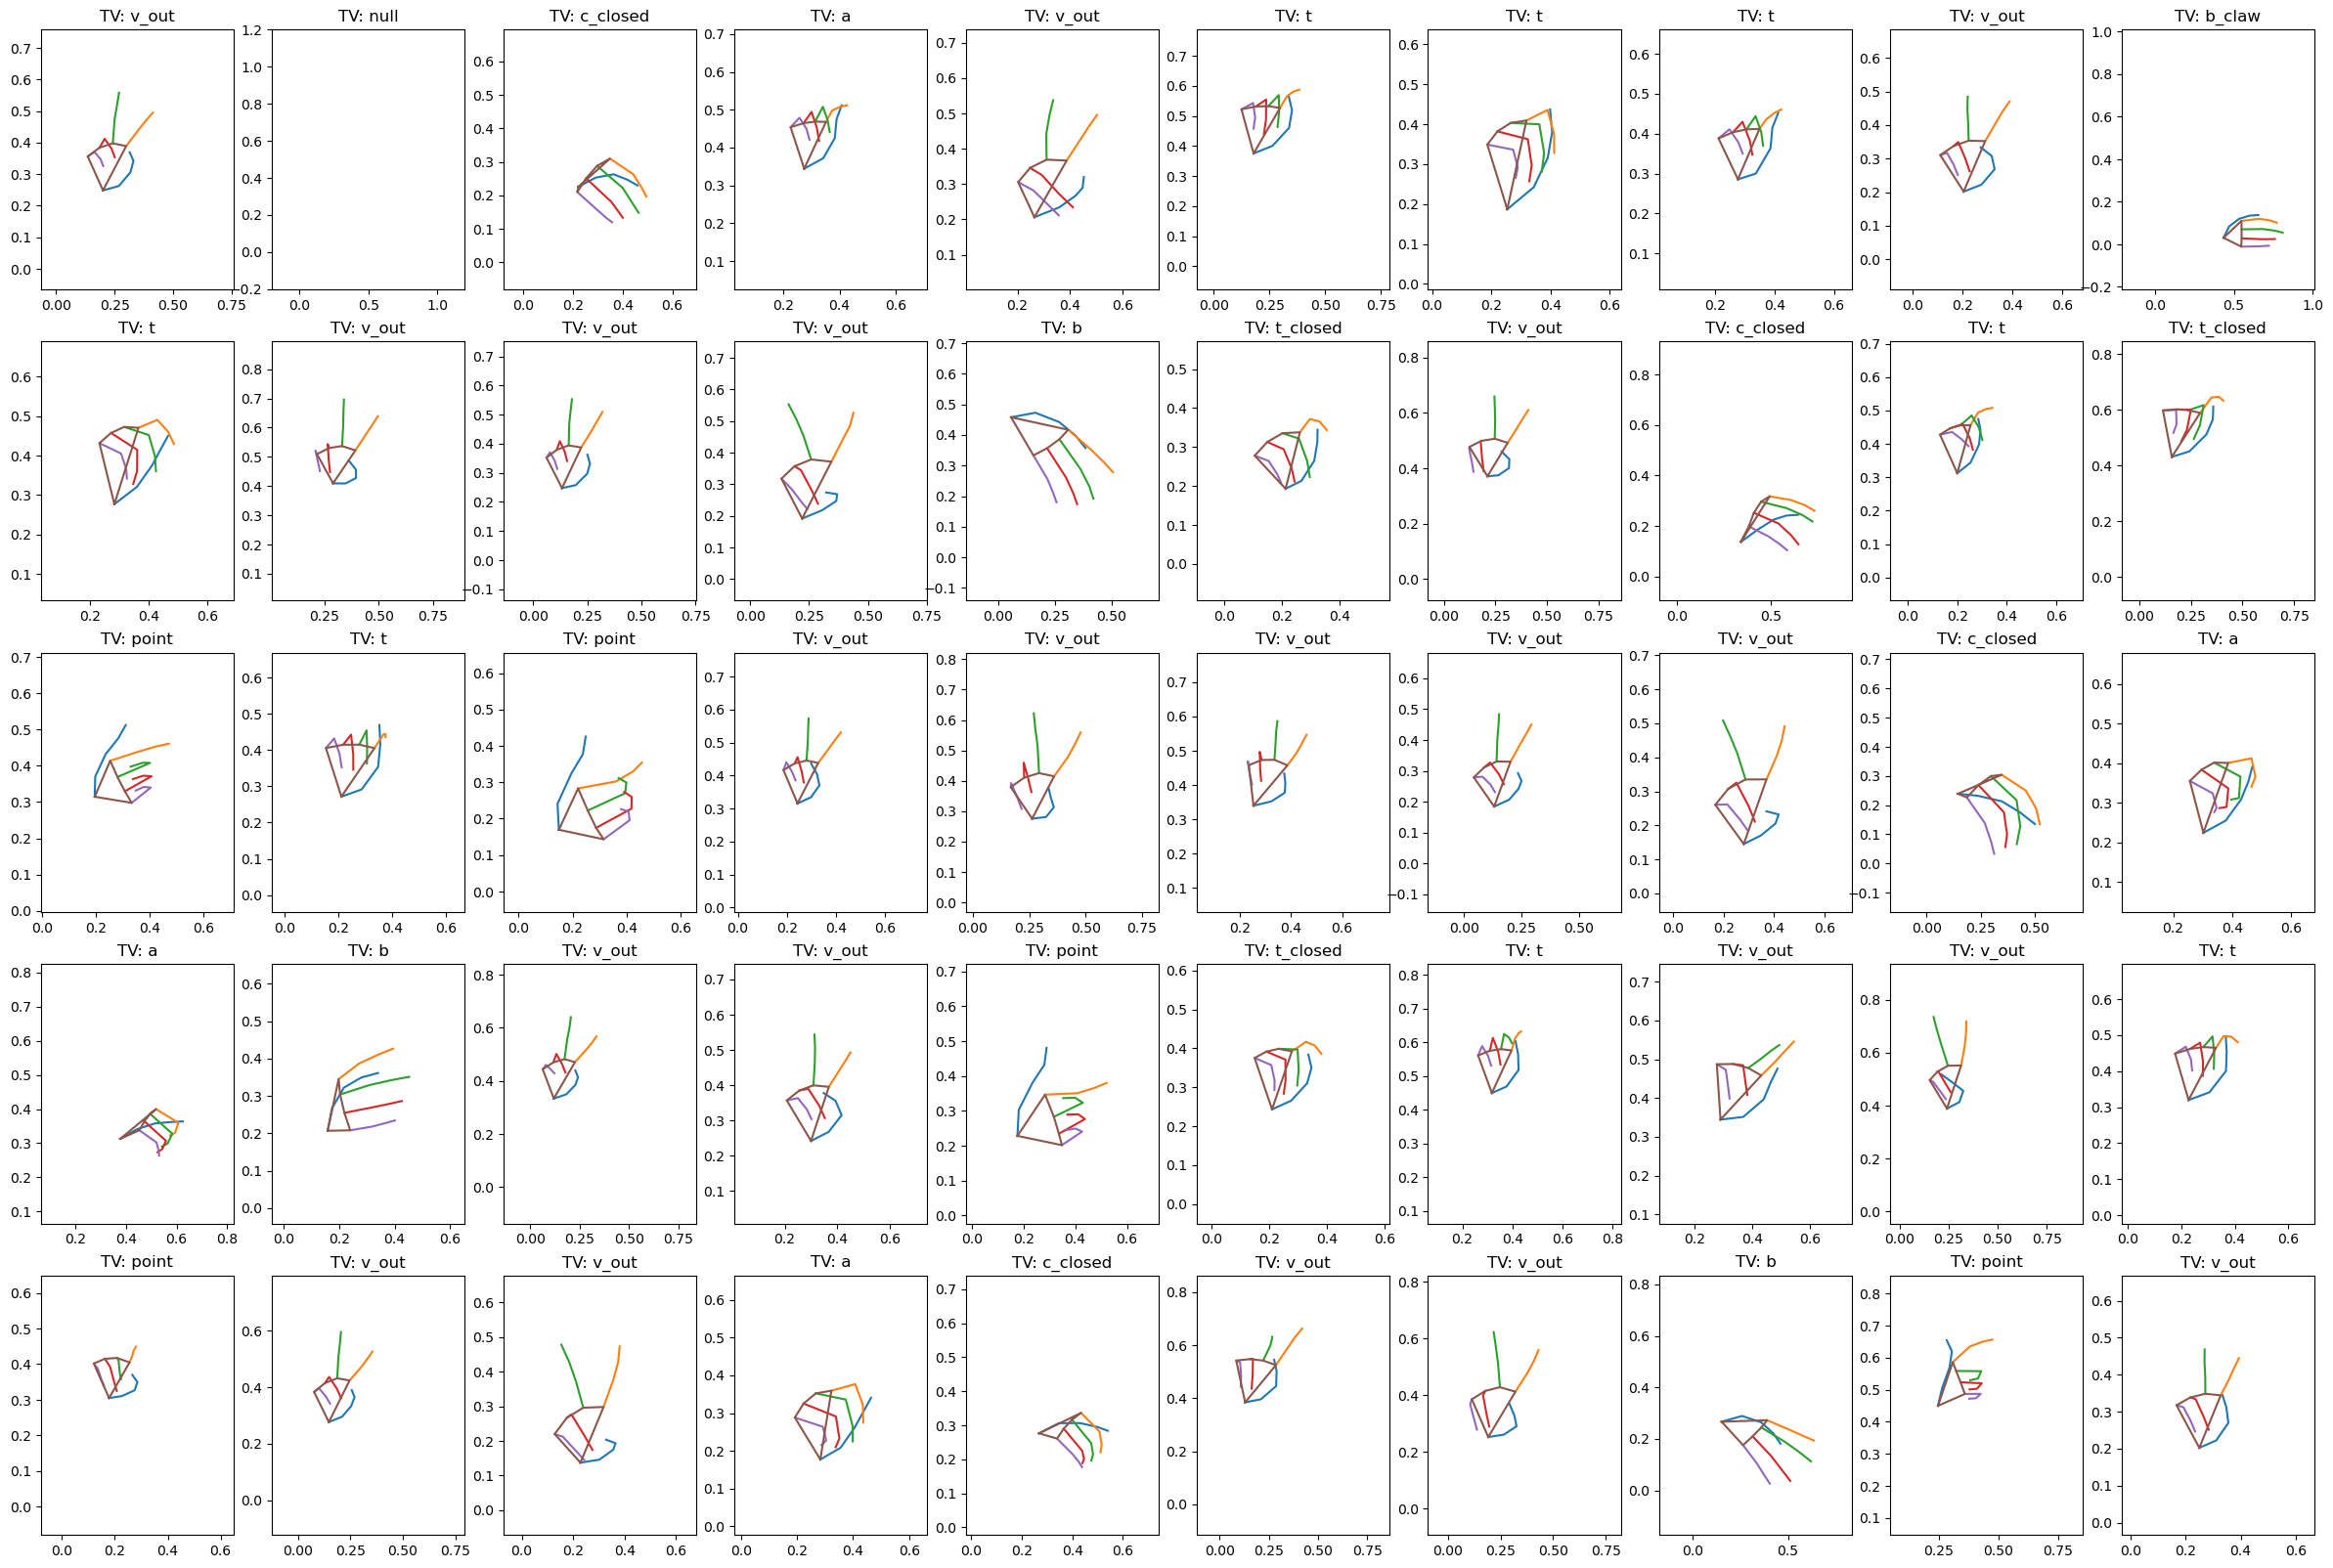

In [15]:
fig = plt.figure(figsize=(5*6, 10*2))

for j in range(k):
    ax = fig.add_subplot(5, 10, j+1)
    f_rhand = representative_frames[j].reshape(-1,2).copy()
    label = f'{representative_frame_labels[j]}: {handshapes[y_representatives[j]]}'
    viz_hand(
        ax=ax,
        hand_frame=f_rhand,
        label=label,
    )

#### Propogate

In [16]:
kmeans.labels_.shape

(5775,)

In [17]:
y_propogated = np.empty(len(X_sample), dtype=np.int32)
for i in range(k):
    y_propogated[kmeans.labels_==i] = y_representatives[i]

In [18]:
np.unique(y_propogated, return_counts=True)
# k

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([3563, 1049,   52,  171,  613,    7,   50,  169,  101]))

In [19]:
percentile_closest = 20

X_clust_dist = X_kmeans_dist[np.arange(len(X_sample)), kmeans.labels_]
X_clust_dist.shape

(5775,)

(array([3572.,  446.,  932.,  510.,  233.,   46.,   17.,    7.,    8.,
           4.]),
 array([2.54429474e-15, 6.18549512e-02, 1.23709902e-01, 1.85564854e-01,
        2.47419805e-01, 3.09274756e-01, 3.71129707e-01, 4.32984659e-01,
        4.94839610e-01, 5.56694561e-01, 6.18549512e-01]),
 <BarContainer object of 10 artists>)

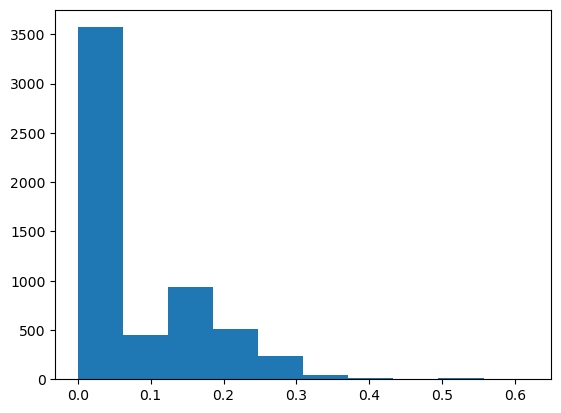

In [20]:
plt.hist(x=X_clust_dist)

In [21]:
percentile_closest = 20

X_clust_dist = X_kmeans_dist[np.arange(len(X_sample)), kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_clust_dist[in_cluster]
    cutoff_dist = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_clust_dist > cutoff_dist)
    # print(in_cluster.shape, above_cutoff.shape)
    #
    # print(f'{cutoff_dist=}')
    # print(i, X_clust_dist[in_cluster].shape, X_clust_dist[in_cluster & above_cutoff].shape)
    X_clust_dist[in_cluster & above_cutoff] = -1


partially_propogated = (X_clust_dist != -1)
X_partial_propogated = X_sample[partially_propogated]
y_partial_propogated = y_propogated[partially_propogated]

np.unique(y_partial_propogated, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32),
 array([3563,  224,   12,   37,  126,    2,   12,   35,   26]))

In [22]:

partially_propogated = (X_clust_dist != -1)
X_partial_propogated = X_sample[partially_propogated]
y_partial_propogated = y_propogated[partially_propogated]

X_partial_propogated.shape, y_partial_propogated.shape

((4037, 42), (4037,))

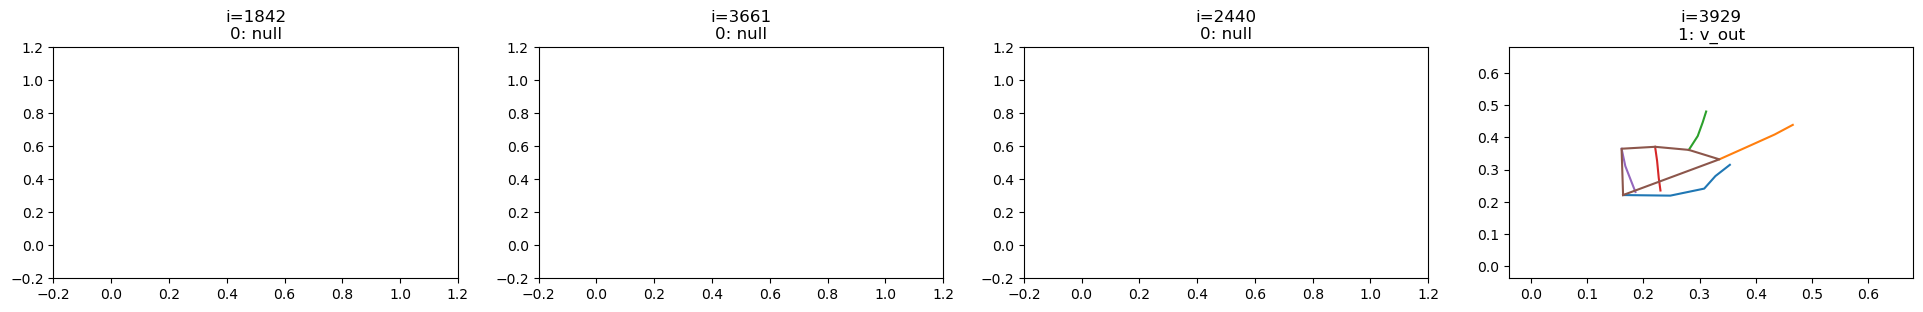

In [23]:
n_examples = 4

index_ = np.random.randint(0,len(X_partial_propogated))
fig = plt.figure(figsize=(6*n_examples, 3))

for count,i in enumerate(np.random.randint(0,len(X_partial_propogated), n_examples)):
    f_rhand = X_partial_propogated[i].reshape(-1,2).copy()
    label = f'{i=}\n{y_partial_propogated[i]}: {handshapes[y_partial_propogated[i]]}'

    ax = fig.add_subplot(1,n_examples,count+1)
    viz_hand(
        ax=ax,
        hand_frame=f_rhand,
        label=label,
    )